<a href="https://colab.research.google.com/github/alice202122/2competitionDL/blob/main/final_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)
#### Meme 


Load the dataset

In [6]:
dataset = pd.read_csv('Training.csv').dropna().astype(np.float32)

print(dataset.shape)
dataset.head()
#snow and rain are incremental: for how long it's going to rain or snaw

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.976980,4.33494,10.672820,1.76692,3.22440,51.681461,3.65434
1,8.078239,4.44616,10.561601,1.70716,3.32566,51.563599,3.47672
2,8.028440,4.22372,10.561601,1.64906,3.17460,50.863079,3.47672
3,8.028440,4.22372,10.561601,1.70716,3.17460,45.841579,3.47672
4,7.875721,4.44616,10.450379,1.70716,3.27586,47.126423,3.47672


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float32
 1   Wonder level        68528 non-null  float32
 2   Crunchiness         68528 non-null  float32
 3   Loudness on impact  68528 non-null  float32
 4   Meme creativity     68528 non-null  float32
 5   Soap slipperiness   68528 non-null  float32
 6   Hype root           68528 non-null  float32
dtypes: float32(7)
memory usage: 2.4 MB


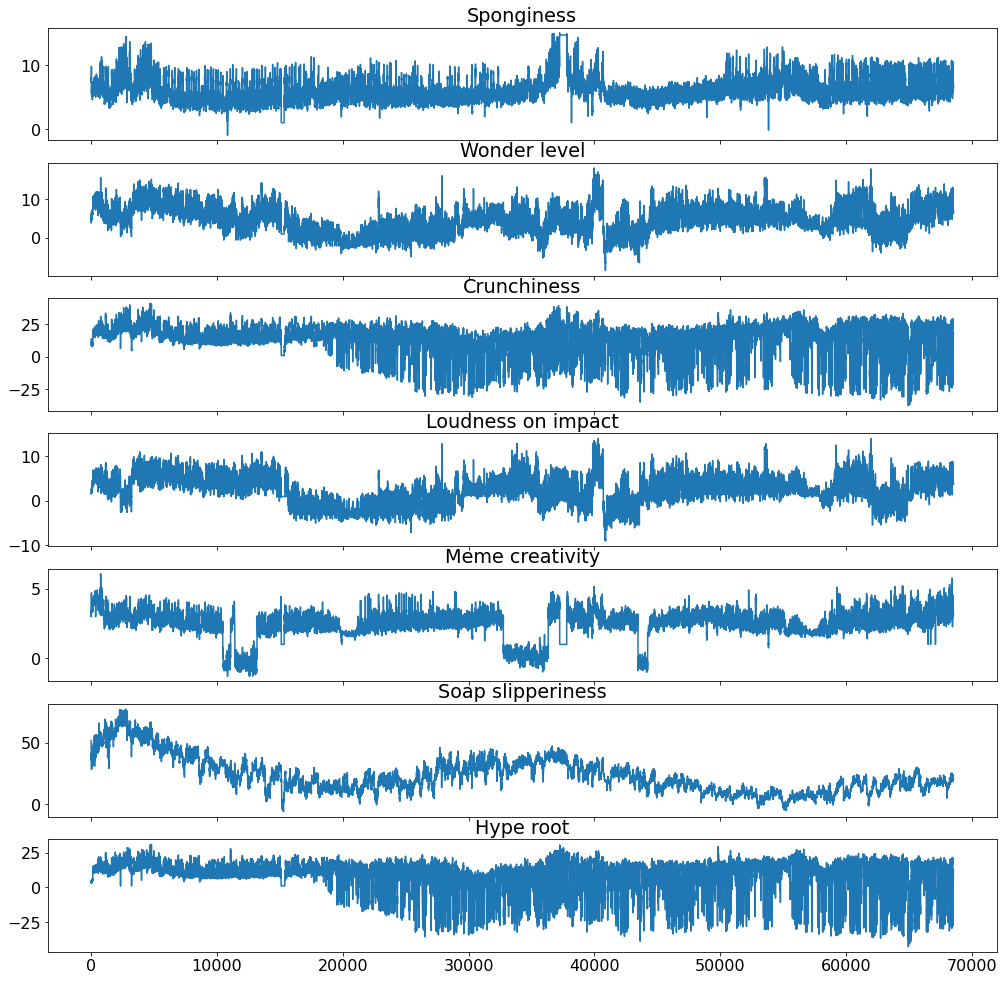

In [8]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

multivariate forecasting: we are going to predict all these 7 dimensions
we want to predict what there is in the future, for a good prediction after the training best epoch
retrian the model also on test. the test is just a split u have dobne for your purposes.
but in the test there is the higher amount of info we can access. 
how to cross validate? if i do the split and i predict in a shuffled way it may happen in case of no stationary time series, the many info are in the part we don't want to take as training info. 


(65528, 7) (3000, 7)


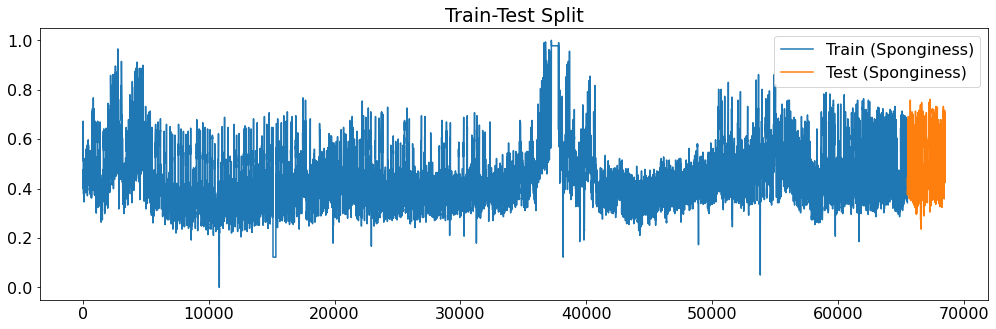

In [37]:
test_size = 3000 #random number
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()
#i dont' use the blu part to train the orange!!!!!

In [38]:
window = 200
stride = 20 #random numbers

In [39]:
future = dataset[-window:] #we take the last window and we predict starting from these
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape


(1, 200, 7)

In [40]:
#telescope argument= how many time points we want to predict.
#we start by looking at the previous 100 points
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = [] #we create 2 lists
    labels = []
    temp_df = df.copy().values #our x variable
    temp_label = df[target_labels].copy().values #the label can be one singole column, a subset of the entrie set of columns or all the columns
    padding_len = len(df)%window

    if(padding_len != 0): 
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Autoregressive model


In [41]:
target_labels = dataset.columns
telescope = 1


In [42]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
#we apply thenext functions to both test and train
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3270, 200, 7), (3270, 1, 7), (140, 200, 7), (140, 1, 7))

In [43]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

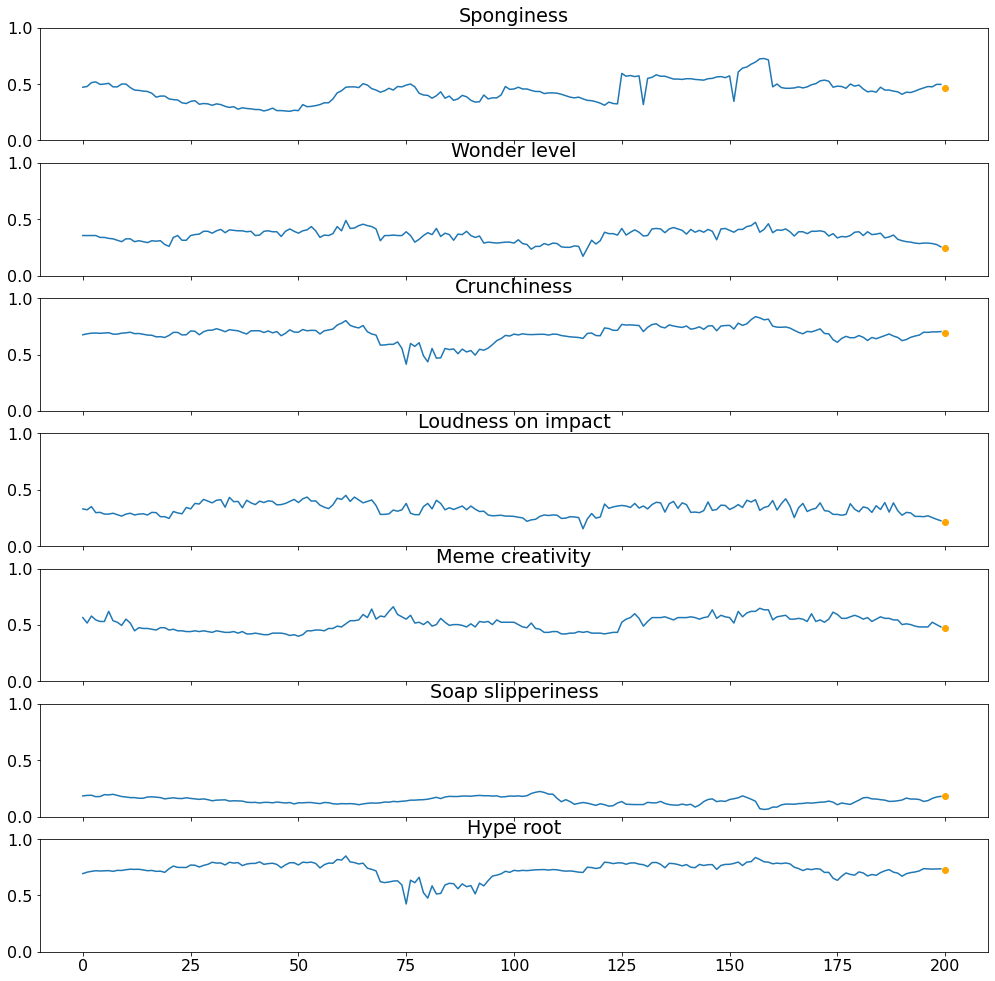

In [44]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [45]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [46]:
from pandas.core.dtypes.cast import convert_dtypes
#merge convolution and recurrent networks
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)

    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    #try without dense
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    #this could be the last layer
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])
    #try different errors

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 200, 7)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 200, 128)         36864     
 nal)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 128)         0         
 1D)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 100, 256)         263168    
 nal)                                                            
                                                             

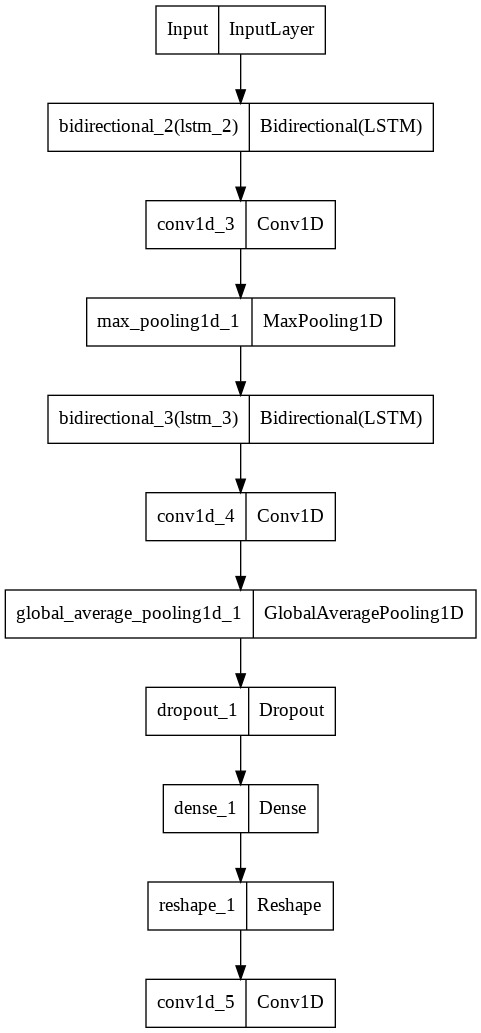

In [47]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [48]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
46/46 [==============================] - 18s 225ms/step - loss: 0.2441 - mae: 0.4567 - val_loss: 0.2020 - val_mae: 0.4062 - lr: 0.0010
Epoch 2/200
46/46 [==============================] - 9s 187ms/step - loss: 0.1747 - mae: 0.3696 - val_loss: 0.1304 - val_mae: 0.3144 - lr: 0.0010
Epoch 3/200
46/46 [==============================] - 9s 188ms/step - loss: 0.0983 - mae: 0.2589 - val_loss: 0.0487 - val_mae: 0.1786 - lr: 0.0010
Epoch 4/200
46/46 [==============================] - 9s 188ms/step - loss: 0.0356 - mae: 0.1470 - val_loss: 0.0254 - val_mae: 0.1095 - lr: 0.0010
Epoch 5/200
46/46 [==============================] - 9s 187ms/step - loss: 0.0192 - mae: 0.1062 - val_loss: 0.0228 - val_mae: 0.1140 - lr: 0.0010
Epoch 6/200
46/46 [==============================] - 9s 187ms/step - loss: 0.0176 - mae: 0.1020 - val_loss: 0.0218 - val_mae: 0.1056 - lr: 0.0010
Epoch 7/200
46/46 [==============================] - 9s 188ms/step - loss: 0.0162 - mae: 0.0975 - val_loss: 0.0215 - val_ma

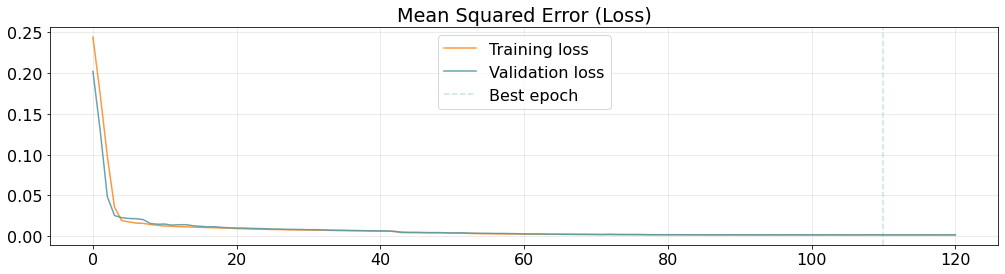

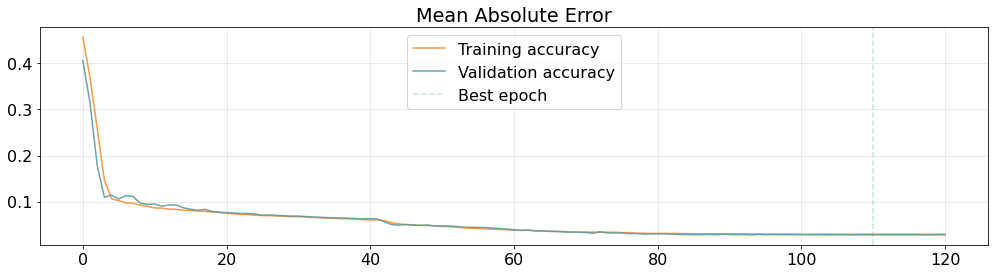

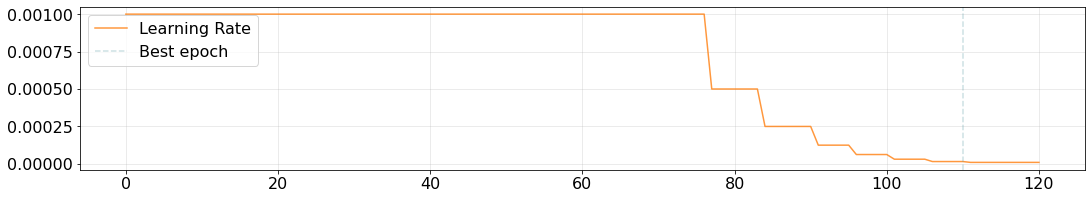

In [51]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [53]:
model.save('autoregressive_c_try')
#filename = 'autoregressive_sioutl_try'
#filename_chosen = os.path.join(model_directory, filename)
#model.save(filename_chosen + '.h5')
model = tfk.models.load_model('autoregressive_c_try')

In [54]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(140, 1, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.00120708>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.024165722>)

In [55]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

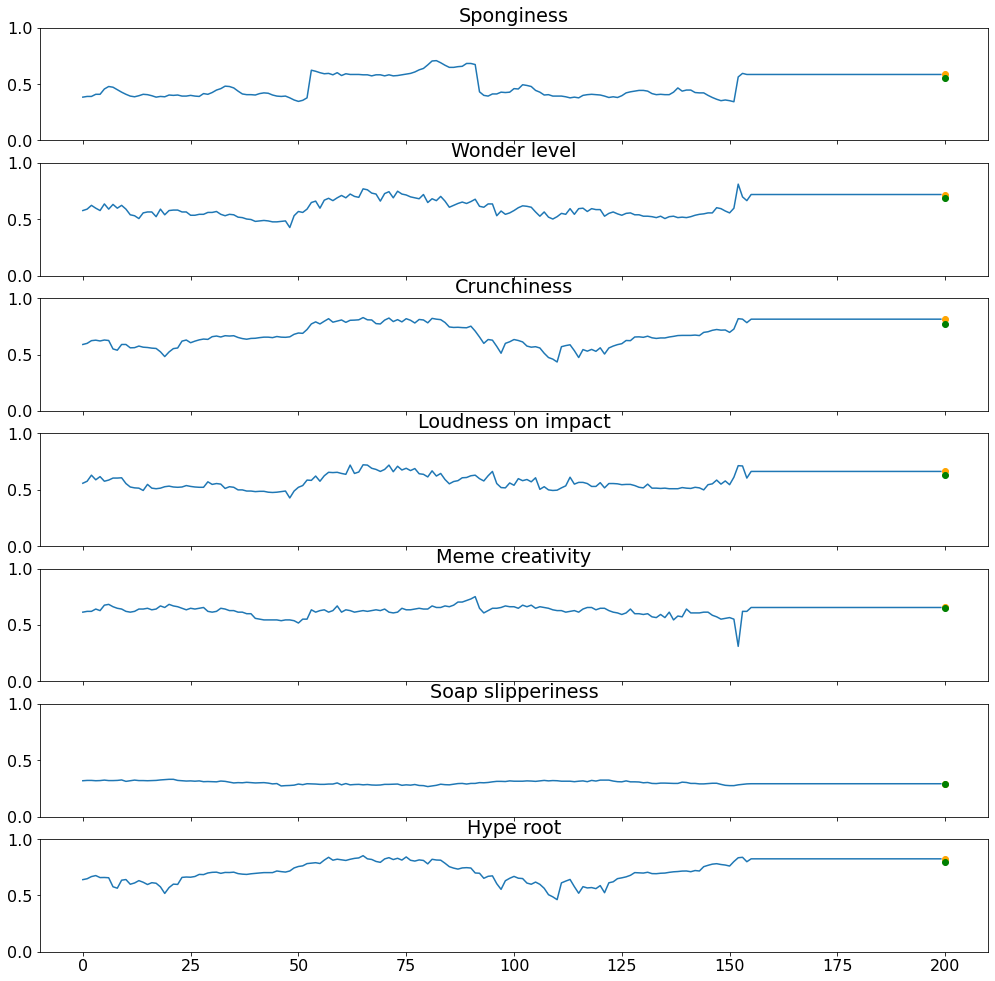

In [56]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [57]:
reg_telescope =864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((97, 200, 7), (97, 864, 7))

In [58]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp) #one point
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1) #we create a new x temp and we concatenate the prediction

In [59]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.03212633>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.14915617>)

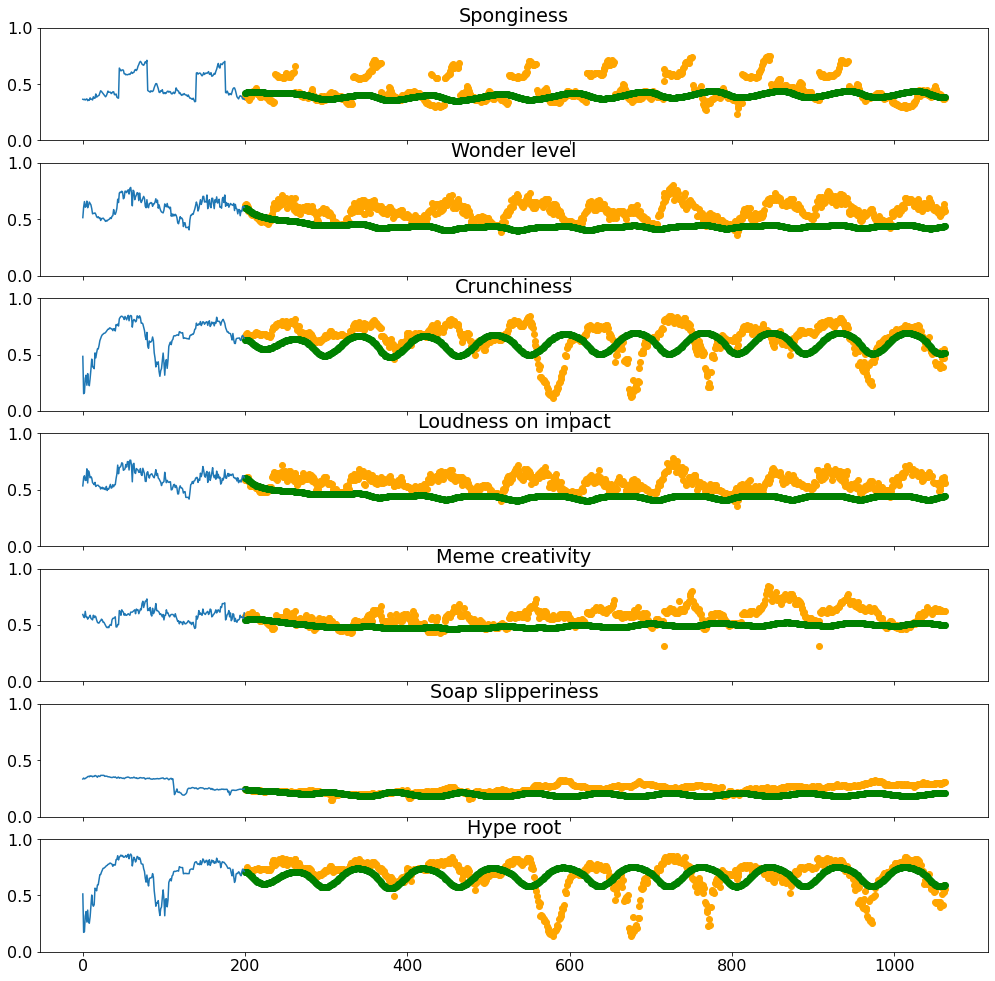

In [31]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

In [32]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [33]:
reg_future = np.array([])
X_temp = future
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

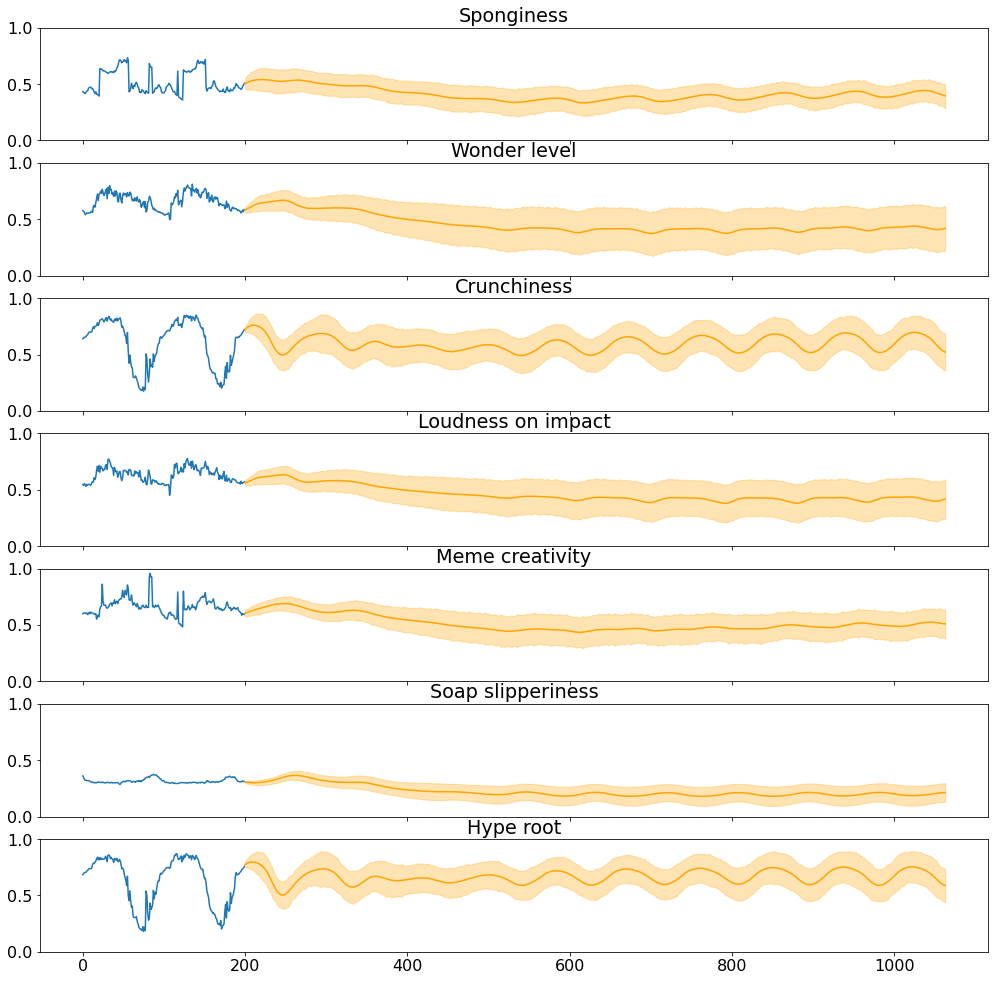

In [34]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()